In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import astropy.units as u

from shared_astro_utils import matching_utils
from zoobot.active_learning import metrics, simulation_timeline

/data/miniconda3/envs/zoobot/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Data/repos/zoobot/zoobot/active_learning/metrics.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python

# Investigate Active Learning Subject Selection (Including Through Time)

### Select Question to Investigate

In [19]:
QUESTION = 'smooth'
save_dir = '../analysis/active_learning_gz2_smooth'
n_acquired = 128

# QUESTION = 'bars'
# save_dir = '../analysis/active_learning_gz2_bars'
# n_acquired = 256

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### Load Catalog (for subject details)

In [4]:
gz2_catalog_loc = '../data/gz2/gz2_classifications_and_subjects.csv'
if not os.path.isfile(gz2_catalog_loc):
    !dvc pull -r s3 {gz2_catalog_loc}.dvc
gz2_catalog = pd.read_csv(gz2_catalog_loc, usecols=None, dtype={'subject_id': str})

In [5]:
# catalog = gz2_catalog
# del gz2_catalog
# TODO could extend this to include NSA catalog properties, but matching all is a bit tricky

In [6]:
# gz2 catalog doesn't have nsa, let's merge that in for astro features
nsa_catalog_loc = '../data/nsa_v1_0_1.fits'
if not os.path.isfile(nsa_catalog_loc):
    !dvc pull -r s3 {nsa_catalog_loc}.dvc

In [7]:
nsa_catalog = Table.read(nsa_catalog_loc)

In [8]:
# nsa_catalog.colnames

In [9]:
useful_cols = ['RA', 'DEC', 'PETRO_BA50', 'PETRO_BA90', 'MAG', 'ELPETRO_MASS']
nsa_catalog = nsa_catalog[useful_cols + ['Z']]
nsa_catalog['redshift'] = nsa_catalog['Z']
del nsa_catalog['Z']
for col in useful_cols:  
    nsa_catalog[col.lower()] = nsa_catalog[col]
    del nsa_catalog[col]
nsa_catalog = nsa_catalog.to_pandas()

In [10]:
catalog, _ = matching_utils.match_galaxies_to_catalog_pandas(gz2_catalog, nsa_catalog, matching_radius=u.arcsec * 10000)

In [11]:
len(catalog), len(gz2_catalog), len(nsa_catalog)

(239695, 239695, 641409)

In [12]:
# to conserve memory
del gz2_catalog
del nsa_catalog

In [13]:
# rename for consistency with Panoptes
catalog['smooth-or-featured_smooth_count'] = catalog['t01_smooth_or_features_a01_smooth_count']
catalog['smooth-or-featured_smooth_fraction'] = catalog['t01_smooth_or_features_a01_smooth_fraction']

catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['bar_yes_fraction'] = catalog['t03_bar_a06_bar_fraction']
catalog['bar_total-votes'] = catalog['t03_bar_a06_bar_count'] + catalog['t03_bar_a07_no_bar_count']

In [14]:
catalog['subject_id'] = catalog['id'].astype(str)
if QUESTION == 'smooth':
    catalog['total_votes']  = catalog['smooth-or-featured_total-votes']
    catalog['label']  = catalog['t01_smooth_or_features_a01_smooth_count']
elif QUESTION == 'bars':
    catalog['total_votes']  = catalog['bar_total-votes']
    catalog['label']  = catalog['t03_bar_a06_bar_count']

### Download Pickled Iteration States

In [15]:
if QUESTION == 'smooth':
    states_dir = '../results/al_mutual_128px_smooth_0e0d3cb7/states'
    # n_acquired = 128
    !aws s3 sync --exclude "*" --include "*.pickle" s3://galaxy-zoo/results/al_mutual_128px_smooth_0e0d3cb7 {states_dir}
if QUESTION == 'bars':
    states_dir = '../results/al-iter-arms-53128718-mutual-bars-with-pickle'
    n_acquired = 256
    !aws s3 sync --exclude "*" --include "*.pickle" s3://galaxy-zoo/results/al-iter-arms-53128718-mutual-bars-with-pickle {states_dir}

### Load Iteration States as Timeline

In [16]:
states = []
n_iterations = 23
for iteration_n in range(n_iterations):
    state_dir = os.path.join(states_dir, 'iteration_{}'.format(iteration_n))
    states.append(metrics.load_iteration_state(state_dir))

In [17]:
states_dir

'../results/al_mutual_128px_smooth_0e0d3cb7/states'

In [20]:
key_catalog_cols = [
    'smooth-or-featured_smooth_count',
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_total-votes',
    'bar_yes_fraction',
    'bar_total-votes',
    'label',
    'total_votes',
    'subject_id',
    'redshift'
    # TODO more?
] + [col.lower() for col in useful_cols]

# takes a few minutes
timeline = simulation_timeline.Timeline(states, catalog[key_catalog_cols], n_acquired=n_acquired, save_dir=save_dir)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


In [21]:
len(timeline._models)

23

### Pick Feature to Investigate

In [22]:
useful_cols

['RA', 'DEC', 'PETRO_BA50', 'PETRO_BA90', 'MAG', 'ELPETRO_MASS']

In [23]:
value = 'smooth-or-featured_smooth_fraction'
# value = 'bar_yes_fraction'
# value = 'redshift'
# value = 'elpetro_mass'

In [24]:
timeline._models[iteration_n].catalog[value].values[:10]

array([0.43599999, 0.56800002, 0.043     , 0.76899999, 0.15000001,
       0.64099997, 0.40000001, 0.116     , 0.60399997, 0.70300001])

In [26]:
# cosmo.luminosity_distance(timeline._models[iteration_n].catalog[value].values[:10]).value

In [27]:
### Extract Values of Feature

acquired = []
random = []
acquired_dummy = []
random_dummy = []

for iteration_n in range(n_iterations):
    values = timeline._models[iteration_n].catalog[value]
#     values = cosmo.luminosity_distance(timeline._models[iteration_n].catalog[value].values).value
    nan_indices = np.isnan(values)
    values = values[~nan_indices]
    acquired_values = values[:timeline.n_acquired]
    acquired.extend(list(acquired_values))
    random.extend(list(values))
    # dummies records which step was used, for 2D histogram plotting
    acquired_dummy.extend([iteration_n for _ in range(len(acquired_values))])
    random_dummy.extend([iteration_n for _ in range(len(values))])

In [28]:
assert not sum(np.isnan(acquired))

### Visualise Feature By 2D Hist (value by step)

In [29]:
# from matplotlib import colors 

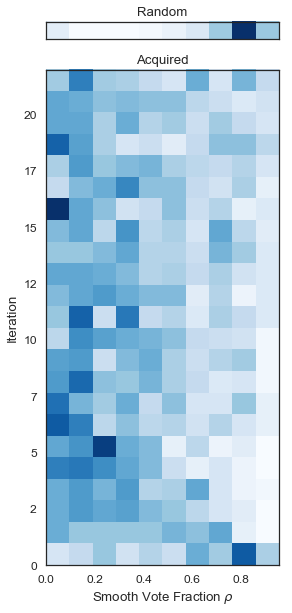

In [30]:

# normalizer = colors.Normalize(vmin=0, vmax=60)

sns.set(font_scale=1.1)
sns.set_style('white')

fig = plt.figure(figsize=(10, 10))
spacing = 0
grid = plt.GridSpec(n_iterations + spacing, 2, wspace=.4, hspace=.4)
ax0 = plt.subplot(grid[:1, 0])  # top bar is a 2D hist with only one y value (1), double height for clarity
ax1 = plt.subplot(grid[2 + spacing:, 0])  # lower plot is 2D hist where y is step and x is values


# fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax0.hist2d(random, np.ones_like(random_dummy), bins=(10, 1), cmap='Blues')
ax0.axes.get_yaxis().set_visible(False)
ax0.axes.get_xaxis().set_visible(False)
# ax0.ticks_visible=False
ax1.hist2d(acquired, acquired_dummy, bins=(10, n_iterations), cmap='Blues')
ax1.set_title('Acquired')
ax0.set_title('Random')
# ax0.set_ylabel('Iteration')
ax1.set_ylabel('Iteration')

if 'smooth' in value:
    ax1.set_xlabel(r'Smooth Vote Fraction $\rho$')
if 'bar' in value:
    ax1.set_xlabel(r'Bar Vote Fraction $\rho$')
if 'redshift' in value:
    ax.set_xlabel(r'Redshift $z$')

ax1.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, pos: '{:d}'.format(int(x))
    )
)
plt.savefig(os.path.join(save_dir, value + 'acquired_by_step.png'))

### Visualise Feature By overlaid 1D Hist (value at each step)

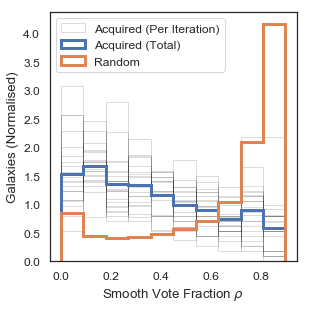

In [33]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4.5, 4.5))
alpha = 0.15
# cmap = plt.get_cmap('magma')
n_bins = 10

all_labels = []
all_acquired_labels = []
for iteration_n in range(n_iterations):
    color_float = iteration_n / n_iterations
    assert isinstance(color_float, float)  # this will fail for python2
    labels = timeline._models[iteration_n].catalog[value]
#     labels = cosmo.luminosity_distance(timeline._models[iteration_n].catalog[value].values).value
    all_labels.extend(labels)
    acquired_labels = labels[:timeline.n_acquired]
    all_acquired_labels.extend(acquired_labels)
    if iteration_n == 0:
        bins = n_bins
        label = 'Acquired (Per Iteration)'
    else:
        label = None
    _, bins, _ = ax.hist(acquired_labels, bins=bins, alpha=alpha, histtype='step', color='k', density=True, label=label)
bin_width = (bins[-1] - bins[0]) / len(bins)

# timeline._models[iteration_n].catalog[value][:timeline.n_acquired]
ax.hist(all_acquired_labels,histtype='step', bins=bins, density=True, linewidth=3., label='Acquired (Total)')
ax.hist(all_labels,histtype='step', bins=bins, density=True, linewidth=3., label='Random')

if 'smooth' in value:
    ax.set_xlabel(r'Smooth Vote Fraction $\rho$')
    loc = 2
if 'bar' in value:
    ax.set_xlabel(r'Bar Vote Fraction $\rho$')
    loc = 0
if 'redshift' in value:
    ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel('Galaxies (Normalised)')
ax.legend(loc=loc)

fig.tight_layout()
plt.savefig(os.path.join(save_dir, value + 'acquired_overlaid.png'))

In [35]:
np.mean(all_acquired_labels)

0.3799313867000266

In [ ]:
last_model = timeline._models[-1]

In [ ]:
first_model = timeline._models[0]

In [ ]:
plt.hist2d(first_model.catalog['redshift'].values, first_model.abs_rho_error, bins=(20, 30))
plt.ylim([0., 0.3])
plt.ylabel(r'| Expected $\hat{\rho}$ - Observed $\frac{k}{N}$')
plt.xlabel(r'Redshift $z$')

In [ ]:
plt.hist2d(last_model.catalog['redshift'].values, last_model.abs_rho_error, bins=(20, 30))
plt.ylim([0., 0.3])
plt.ylabel(r'| Expected $\hat{\rho}$ - Observed $\frac{k}{N}$ |')
plt.xlabel(r'Redshift $z$')

### Alternative Overlay (Deprecated)

In [ ]:
# sns.set_style('white')
# fig, (ax0, ax1) = plt.subplots(ncols=2)
# alpha = 0.4
# cmap = plt.get_cmap('magma')
# n_bins = 8
# mean_acquired = []
# mean_random = []
# for iteration_n in range(n_iterations):
#     color_float = iteration_n / n_iterations
#     assert isinstance(color_float, float)  # this will fail for python2
#     labels = timeline._models[iteration_n].catalog['bar_yes_fraction']
#     acquired_labels = labels[:timeline.n_acquired]
#     if iteration_n == 0:
#         bins = n_bins
#     acquired_values, bins, _ = ax0.hist(acquired_labels, bins=bins, alpha=alpha, histtype='step', color=cmap(color_float))
#     mean_acquired.append(acquired_values)
#     random_values = ax1.hist(labels, alpha=alpha, histtype='step', bins=bins, color=cmap(color_float))
#     ax0.set_title('Acquired')
#     ax1.set_title('Random')
#     ax0.set_xlabel(r'Bar Vote Fraction $\rho$')
#     ax1.set_xlabel(r'Bar Vote Fraction $\rho$')
# bin_width = (bins[-1] - bins[0]) / len(bins)
# ax0.plot(bins[:-1] + bin_width, np.mean(mean_acquired, axis=0))
# # better: turn other bins to trace, and plot an overall and random histogram
# fig.tight_layout()
# # plt.savefig(os.path.join(save_dir, value + 'acquired_overlaid.png'))